<a href="https://colab.research.google.com/github/sudeepmenon17/PytorchforNN/blob/main/NN_feature_insights_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install google-auth

In [49]:
from google.colab import auth
from google.colab import drive

In [50]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
!pip install keras==2.12.0

In [52]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [53]:
# Read the data set -  Airfoil S809
df1 = pd.read_csv("/content/drive/MyDrive/data_set1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/data_set2.csv")
df3 = pd.read_csv("/content/drive/MyDrive/data_set3.csv")
df4 = pd.read_csv("/content/drive/MyDrive/data_set4.csv")

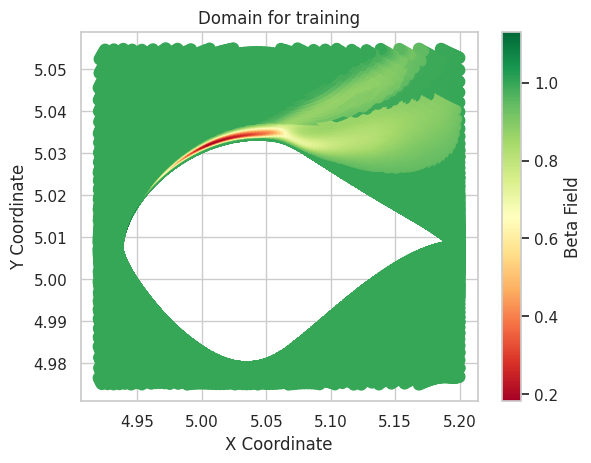

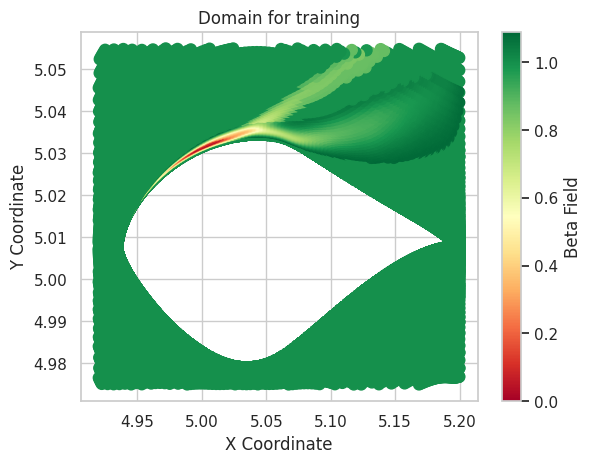

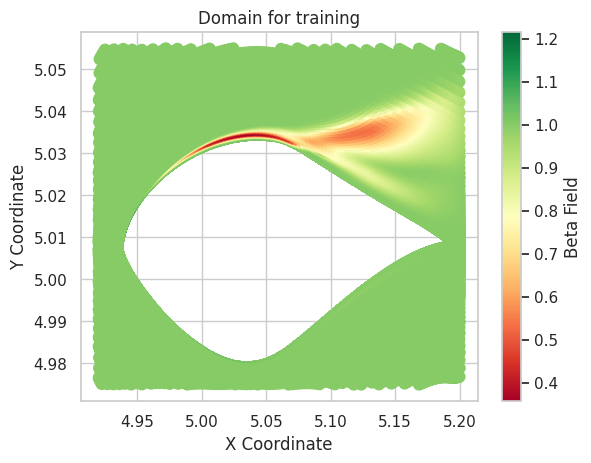

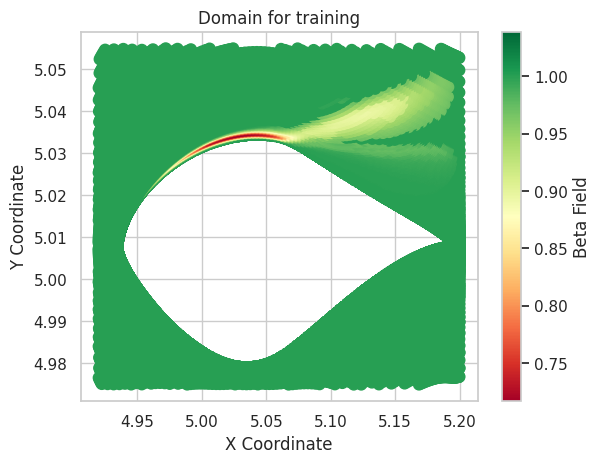

In [54]:
# Combine data
frames = [df1, df2, df3, df4]
ff = []

for item in frames:
  xc = np.array(item['x'])
  yc = np.array(item['y'])
  b = np.array(item['beta'])
  ff1 = np.array(item['feature1'])
  ff2 = np.array(item['feature2'])
  ff3 = np.array(item['feature3'])
  ff4 = np.array(item['feature4'])
  ff5 = np.array(item['feature5'])
  ff6 = np.array(item['feature6'])

  # Normalize x and y coordinates
  min_range = -5.0
  max_range = 5.0
  xc = (xc - np.min(xc)) * (max_range - min_range) / (np.max(xc) - np.min(xc))
  yc = (yc - np.min(yc)) * (max_range - min_range) / (np.max(yc) - np.min(yc))


  # #####################################################################
  # # Cleaning the beta field in the wake region
  # for k in range(len(xc)):
  #   if xc[k] >= 5.2 and xc[k] <= 5.3:
  #     if yc[k] >= 5.00 and yc[k] <= 4.96:
  #       b2.append(b[k])

  # for j in range(len(xc)):
  #   if xc[j] > 5.15 or yc[j]>5.04:
  #     b[j] = np.mean(b2)

  x1,y1,b1,f1,f2,f3,f4,f5,f6 = [[] for i in range(9)]
  # Filter data for the specified range of coordinates
  for i in range(len(xc)):
    if xc[i]>=4.92 and xc[i]<=5.20:
      if yc[i]>=4.975 and yc[i]<=5.055:
        x1.append(xc[i])
        y1.append(yc[i])
        b1.append(b[i])
        f1.append(ff1[i])
        f2.append(ff2[i])
        f3.append(ff3[i])
        f4.append(ff4[i])
        f5.append(ff5[i])
        f6.append(ff6[i])

  modified_data = {
  'x': np.array(x1),
  'y': np.array(y1),
  'beta': np.array(b1),
  'feature1': np.array(f1),
  'feature2': np.array(f2),
  'feature3': np.array(f3),
  'feature4': np.array(f4),
  'feature5': np.array(f5),
  'feature6': np.array(f6)
  }


  ff.append(pd.DataFrame(modified_data))

  # # #####################################################################
  # # Plotting cleaned data
  # ################################
  # nx = []
  # ny = []
  # nb = []


  # # Filter data for the specified range of coordinates
  # for i in range(len(xc)):
  #   if xc[i]>=4.9 and xc[i]<=5.3:
  #     if yc[i]>=4.925 and yc[i]<=5.075:
  #       nx.append(xc[i])
  #       ny.append(yc[i])
  #       nb.append(b[i])

  # Create a scatter plot
  plt.scatter(x1, y1, c=b1,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
  plt.colorbar(label='Beta Field')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.title('Domain for training')
  plt.show()
###############################################################################

df = pd.concat(ff)


# Data for beta>1.02 or beta<0.98
df_filtered = df[(df['beta'] < 0.995) | (df['beta'] > 1.005)]

# df_filtered = df[df['beta'] != 1.0]

# df_filtered = df


In [55]:
dff = df_filtered.sort_index() # Training data after excluding beta=[0.995,1.005]
print(dff.columns.values)

['x' 'y' 'beta' 'feature1' 'feature2' 'feature3' 'feature4' 'feature5'
 'feature6']


In [56]:
dff = dff.drop(['x','y'],axis=1)
dff.describe()

,beta,feature1,feature2,feature3,feature4,feature5,feature6
count,17606.000000,17606.000000,17606.000000,17606.000000,17606.000000,17606.000000,17606.000000
mean,0.910430,77.358729,308.289149,0.977094,18.294946,437.439875,0.304028
std,0.170106,190.730427,608.339907,0.229684,162.296995,2259.318034,0.413005
min,0.000000,0.016143,1.097497,0.012101,0.001637,0.000731,0.000000
25%,0.871114,9.753538,14.393383,0.976376,1.344307,1.707943,0.000000
50%,0.975271,23.772834,41.736330,0.990525,2.243298,7.673603,0.000142
75%,1.010625,61.619579,225.749800,1.005237,17.071570,50.619712,0.792631
max,1.216039,1547.650392,3343.469421,18.876581,9756.682568,24298.278480,0.999971


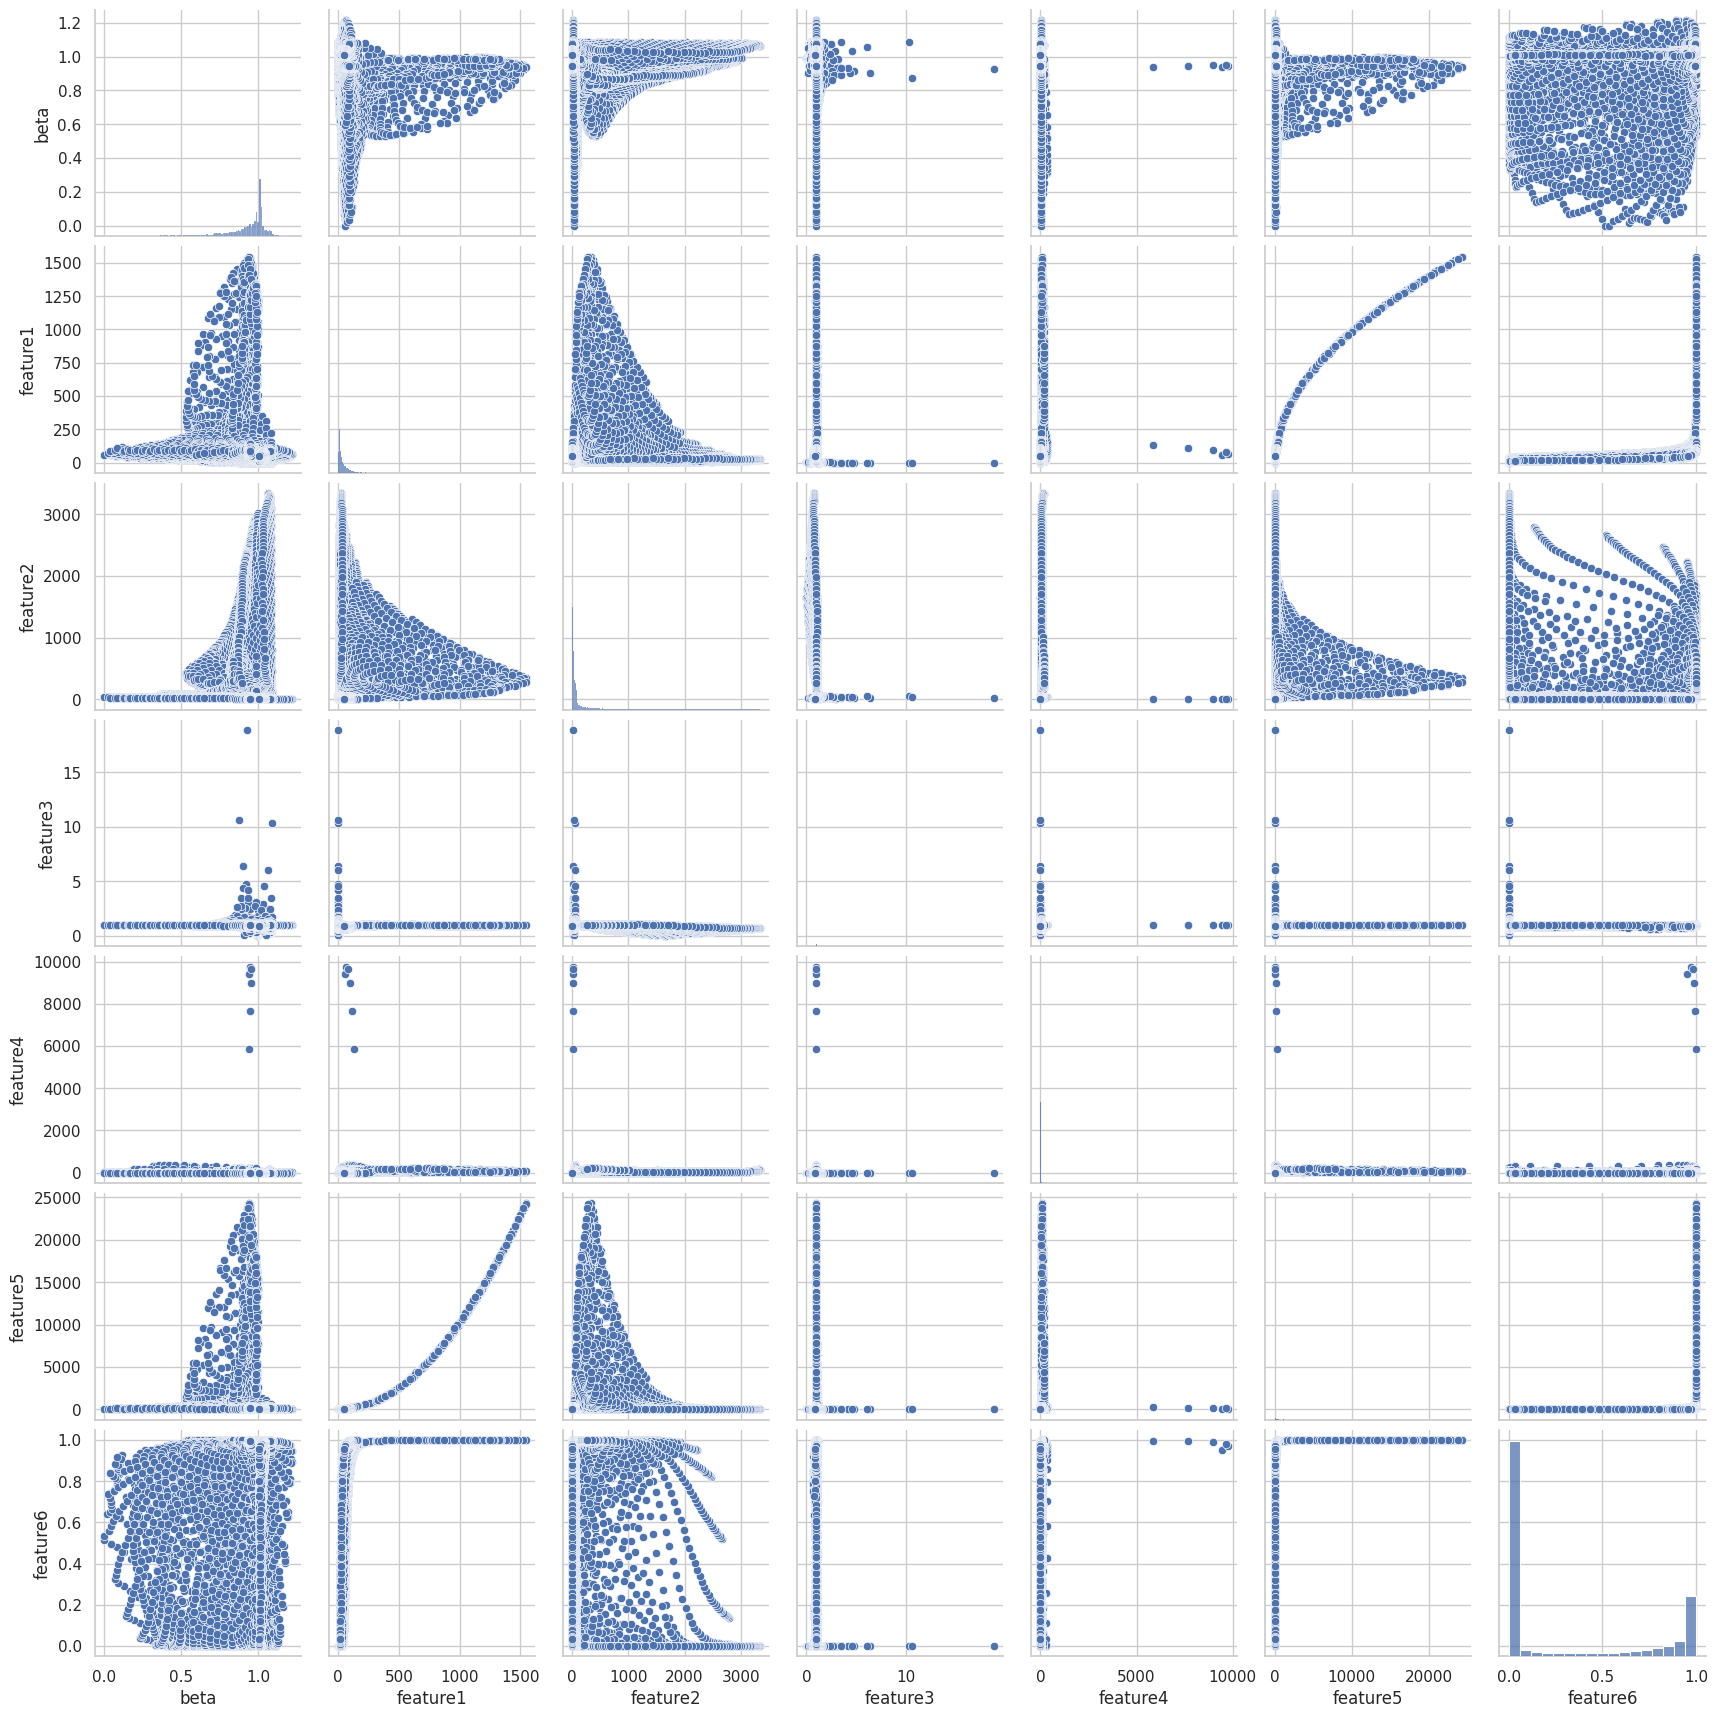

In [57]:
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
# Pair plot
sns.pairplot(dff)

<Axes: xlabel='feature6', ylabel='Density'>

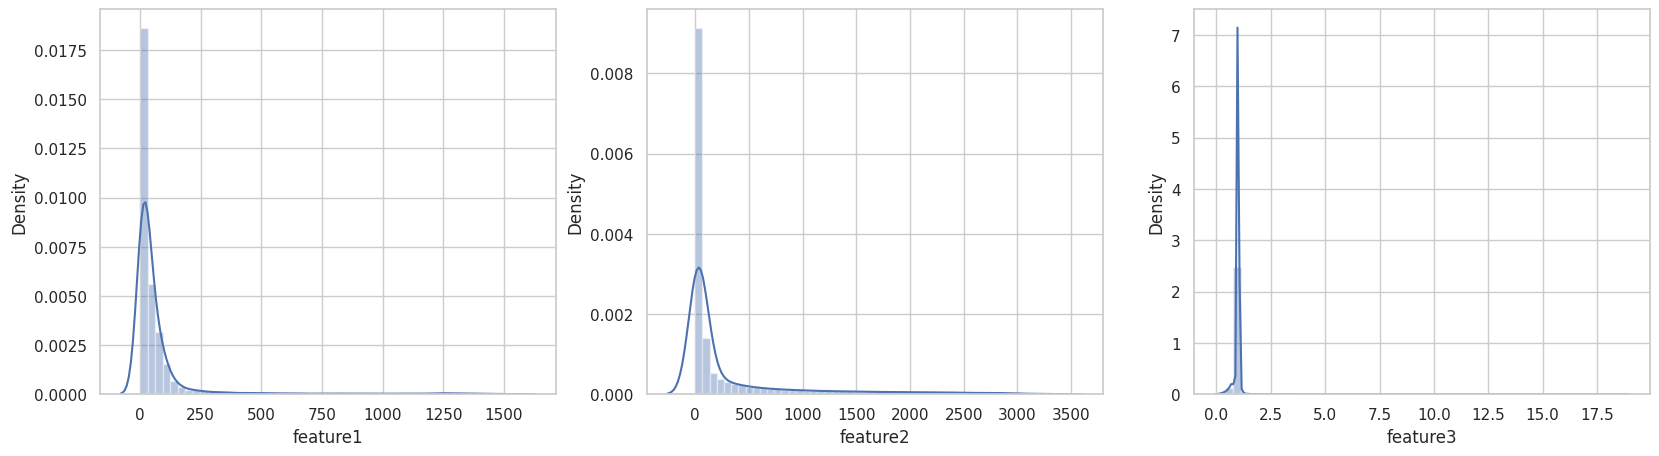

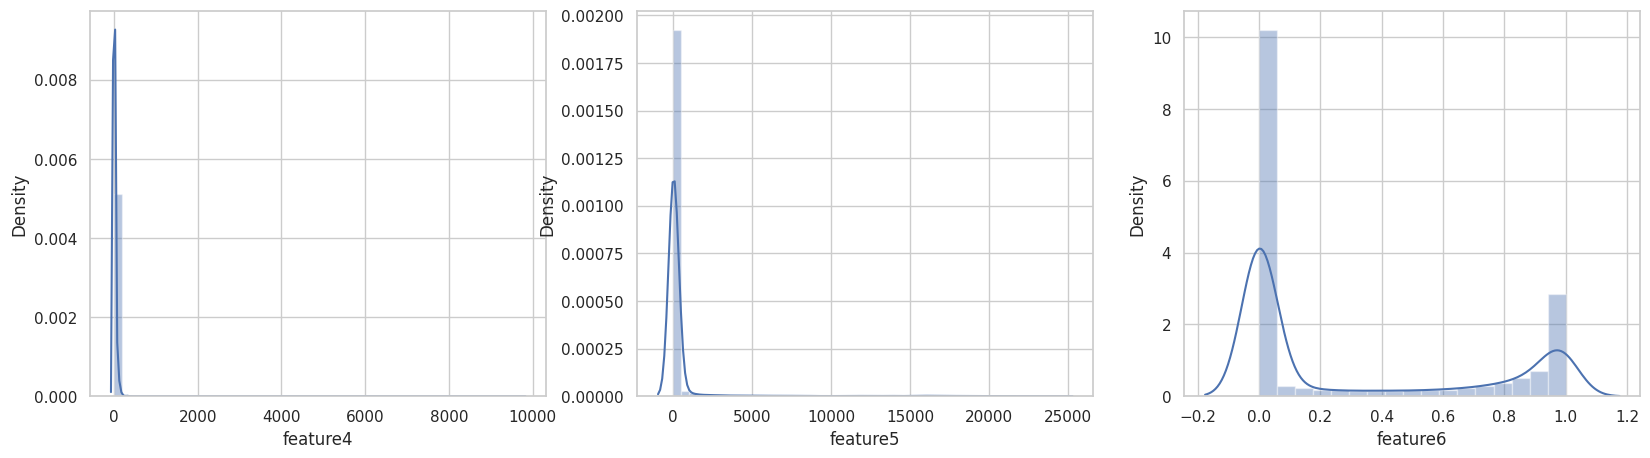

In [58]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(dff['feature1'])
plt.subplot(1,3,2)
sns.distplot(dff['feature2'])
plt.subplot(1,3,3)
sns.distplot(dff['feature3'])

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(dff['feature4'])
plt.subplot(1,3,2)
sns.distplot(dff['feature5'])
plt.subplot(1,3,3)
sns.distplot(dff['feature6'])

In [59]:
df1 = dff.drop('beta',axis=1)
df2 = dff['beta']

In [60]:
# Split the data into test and training sets.
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(df1,df2,test_size=0.2)
# Print the dimensions
print('Training set dimensions X, y: ' + str(X_train.shape) + ' ' +str(y_train.shape))
print('Test set dimensions X, y: ' + str(X_test.shape) + ' '+ str(y_test.shape))

Training set dimensions X, y: (14084, 6) (14084,)
Test set dimensions X, y: (3522, 6) (3522,)


In [61]:
# Define regression model in Keras
def regression_model():
    # Define model
    model = Sequential()
    model.add(Dense(61, input_dim=6, activation='sigmoid'))
    model.add(Dense(60, activation='sigmoid'))
    model.add(Dense(1, activation='linear'))
    # Compile model
    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=adam,metrics=['accuracy'])

    return model

# Use KerasRegressor wrapper (from Keras to sklearn)
# The packages we use are meant to be run with sklearn models
estimator = KerasRegressor(build_fn=regression_model, validation_split = 0.2, batch_size=100, epochs=1000, verbose=0)
history = estimator.fit(X_train, y_train)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


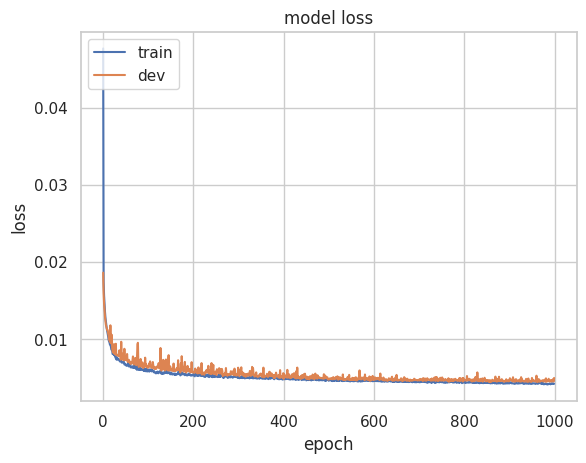

In [62]:
# summarize history loss
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [64]:
fitted = estimator.predict(X_train)
residuals = y_train - fitted

TypeError: kdeplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

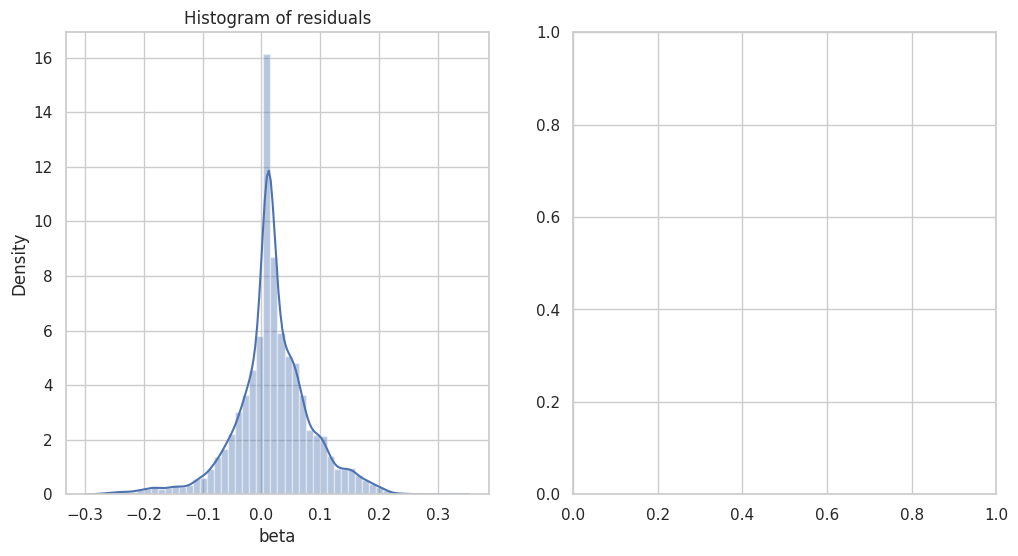

In [67]:
# Two plots
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(12,6))

# 1. Histogram of residuals
sns.distplot(residuals, ax=ax1)
ax1.set_title('Histogram of residuals')

# Fitted vs residuals
x1 = pd.Series(fitted, name='Fitted beta')
x2 = pd.Series(y_train, name="beta values")
sns.kdeplot(x1, x2, n_levels=40,ax = ax2)
sns.regplot(x=x1,y=x2, scatter=False, ax = ax2)
ax2.set_title('Fitted vs actual values')
# ax2.set_xlim([0,120])
# ax2.set_ylim([0,120])
ax2.set_aspect('equal')